# Measuring Transport Accessbility

A simple example using `tracc` for the Boston region

In [1]:
import sys
sys.path.append("..")

import tracc
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib

%matplotlib inline

Load in the destination data. For this example, these are job counts by block group from the the LEHD and SNAP grocery stores.

In [2]:
dfo = pd.merge(
        pd.read_csv("test_data/boston/destination_employment_lehd.csv"),
        pd.read_csv("test_data/boston/destination_groceries_snap.csv"),
        how = "outer",
        left_on = "block_group_id",
        right_on = "GEOID"
)

Create a supply object (i.e. a dataset of destinations), for only the columns in which we want to compute accessibility for. In this case, all jobs from the LEHD (var C000), and SNAP grocery stores.

In [3]:
dfo = tracc.supply(
    supply_df = dfo,
    columns = ["block_group_id","C000","snap"]
    )
dfo.data.head()

,block_group_id,C000,snap
0,250056001001,579,NaN
1,250056001002,415,1.0
2,250056002021,3475,1.0
3,250056002022,133,1.0
4,250056002023,887,1.0


Now let's load in travel time data. Here we load in transit travel times that were previously computed in OpenTripPlanner (capped at 120 minutes) for June 30, 2020.

In [4]:
dft = tracc.costs(
    pd.read_csv("test_data/boston/transit_time_matrix_8am_30_06_2020.zip", compression='zip')
    )
dft.data.time = dft.data.time / 60 # converting time from seconds to minutes
dft.data.time = dft.data.time.round(1) # rounding to just one decimal place
dft.data.head()

,o_block,d_block,time
0,250214071005,250173871003,117.9
1,250214071005,250173871004,107.2
2,250214071005,250214061011,103.7
3,250214071005,250214061022,102.2
4,250214071005,250214061024,99.9


Filling in blanks in the travel time matrix

In [13]:
dft.fill_missing_costs(
    where = "origin",
    cost_column = "time",
    origin_column = "o_block",
    destination_column = "d_block",
    spatial_file_path = "test_data/boston/block_group_poly.geojson",
    spatial_file_id = "GEOID"
)

dft.fill_missing_costs(
    where = "destination",
    cost_column = "time",
    origin_column = "o_block",
    destination_column = "d_block",
    spatial_file_path = "test_data/boston/block_group_poly.geojson",
    spatial_file_id = "GEOID"
)

Computing intrazonal travel times

In [6]:
dft.intrazonal(
    cost_column = "time",
    origin_column = "o_block",
    destination_column = "d_block",
    method = "radius",
    value = 1 / 0.0833333333,
    polygon_file = "test_data/boston/block_group_poly.geojson",
    polygon_id = "GEOID"
)

Computing impedance function based on a 45 minute travel time threshold 

In [7]:
dft.impedence_calc(
    cost_column = "time",
    impedence_func = "cumulative",
    impedence_func_params = 45,
    output_col_name = "fCij_c45",
    prune_output = False
)
dft.data.head()

,o_block,d_block,time,fCij_c45
0,250214071005,250173871003,117.9,0
1,250214071005,250173871004,107.2,0
2,250214071005,250214061011,103.7,0
3,250214071005,250214061022,102.2,0
4,250214071005,250214061024,99.9,0


Creating the accessibility object

In [8]:
acc = tracc.accessibility(
        travelcosts_df = dft.data,
        supply_df = dfo.data,
        travelcosts_ids = ["o_block","d_block"],
        supply_ids = "block_group_id"
    )

Measuring potential accessibility to jobs, using a 45 minute cumulative impedance function.

In [9]:
dfa = acc.potential(
        opportunity = "C000",
        impedence = "fCij_c45"
        )
dfa.head()

,o_block,A_C000_fCij_c45
0,250056001001,4061.0
1,250056001002,3960.0
2,250056002021,3608.0
3,250056002022,7845.0
4,250056002023,5124.0


Let's try to visualize the result, first by loading in shape for the Block Groups, joining our output to block groups, then plotting

In [10]:
bg = gpd.read_file("test_data/boston/block_group_poly.geojson")
bg = bg.merge(dfa, left_on='GEOID', right_on = "o_block", how = "left")

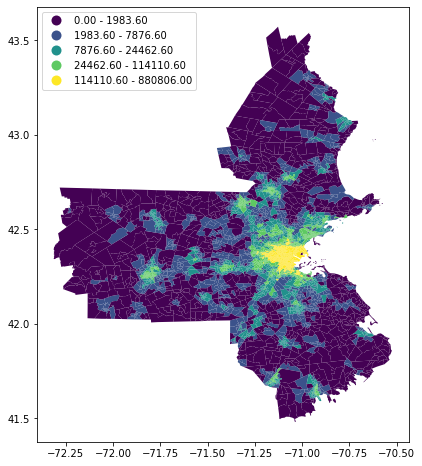

In [11]:
bg.plot(column='A_C000_fCij_c45', figsize=(8, 8), scheme='quantiles', legend=True, legend_kwds={'loc': 'upper left'});

Now let's try to measure access to grocery stores, based on minimum travel time 
(e.g. what is the minimum travel time to reach 2 grocery stores)

In [12]:
dfm = acc.mintravelcost(
        travelcost = "time",
        opportunity = "snap",
        min_n = 3
        )
dfm.head()

,A_mintravelcost_time_snap_3
o_block,
250056001001,34.2
250056001002,31.8
250056002021,58.2
250056002022,46.4
250056002023,53.0


In [13]:
bg = gpd.read_file("test_data/boston/block_group_poly.geojson")
bg = bg.merge(dfm, left_on='GEOID', right_on = "o_block", how = "left")

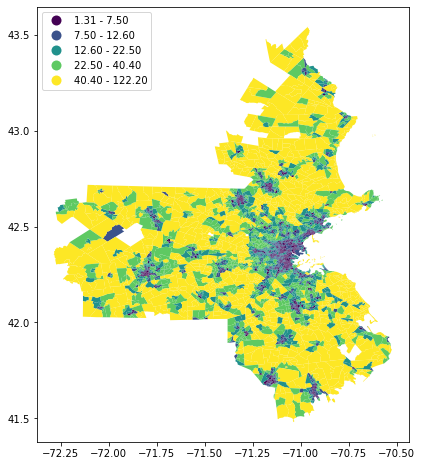

In [14]:
bg.plot(column='A_mintravelcost_time_snap_3', figsize=(8, 8), scheme='Quantiles', legend=True, legend_kwds={'loc': 'upper left'});